In [2]:
!pip install -qU sagemaker
import json
import numpy as np
import pandas as pd
import os
import boto3
import sagemaker
import uuid
import time
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline 
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.session import TrainingInput
from sagemaker import get_execution_role
from sagemaker.utils import name_from_base
from sagemaker.pytorch import PyTorchModel
from sagemaker.serializers import DataSerializer
from sagemaker.deserializers import JSONDeserializer
sm_session = sagemaker.Session()
role = get_execution_role()
s3_resource = boto3.resource('s3')

In [3]:
dataset_s3_uri = "s3://"   # bucket chosen
labels = [""]

In [4]:
#these data sources to the data library in the yolov5 folder for our model to train
def split_s3_path(s3_path):
    path_parts=s3_path.replace("s3://","").split("/")
    bucket=path_parts.pop(0)
    key="/".join(path_parts)
    return bucket, key

def download_dataset(bucket_name, folder):
    bucket = s3_resource.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix = folder):
        if not os.path.exists(os.path.dirname(obj.key)):
            os.makedirs(os.path.dirname(obj.key))
        if os.path.splitext(obj.key)[1]:
            bucket.download_file(obj.key, obj.key)

In [5]:
bucket,dataset_name = split_s3_path(dataset_s3_uri)
download_dataset(bucket, dataset_name)

In [6]:
# 2. EXPLORE THE DATASET

In [7]:
for filename in glob.iglob(dataset_name + '**', recursive=True):
     print(filename)

fishdataset/
fishdataset/images
fishdataset/images/valid
fishdataset/images/valid/00bfa2a9-MVI_3659_35.jpg
fishdataset/images/valid/0a1c7e53-MVI_3659_98.jpg
fishdataset/images/train
fishdataset/images/train/00bfa2a9-MVI_3659_35.jpg
fishdataset/images/train/0a1c7e53-MVI_3659_98.jpg
fishdataset/labels
fishdataset/labels/valid
fishdataset/labels/valid/0a1c7e53-MVI_3659_98.txt
fishdataset/labels/valid/00bfa2a9-MVI_3659_35.txt
fishdataset/labels/train
fishdataset/labels/train/0a1c7e53-MVI_3659_98.txt
fishdataset/labels/train/00bfa2a9-MVI_3659_35.txt


In [8]:
%cd /root

/root


In [9]:
with open("yolov5-latest/data/custom-model.yaml", 'w') as target:
    target.write("path: /opt/ml/input/data/training\n")
    target.write("train: images/train\n")
    target.write("val: images/valid\n")
    target.write("names:\n")
    for i, label in enumerate(labels):
        target.write("  {}: {}\n".format(i, label))
    
        
with open('yolov5-latest/data/custom-model.yaml') as file:
    lines = file.readlines()
    for line in lines:
        print(line)

path: /opt/ml/input/data/training

train: images/train

val: images/valid

names:

  0: fish



In [10]:
# 3. Train the custom YOLOv5 model with SageMaker Training Jobs.

In [11]:
training_name = "yolov5-t"

In [29]:
job_name = '{}-{}'.format(training_name,str(uuid.uuid4()))
print(job_name)

yolov5-t-d049671e-7ff3-4071-8ca3-6f8f2e8964f2


In [30]:
%cd /root

/root


In [31]:
hyperparameters={
    "workers":"4",
    "device": "0",
    "batch-size": "16",
    "epochs": 3,
    "data": "custom-model.yaml",
    "weights": "yolov5s.pt",
    "project": "/opt/ml/model"
}

estimator = PyTorch(
    framework_version='1.11.0',
    py_version='py38',
    entry_point='train.py',
    source_dir='yolov5-latest',
    dependencies=['yolov5-latest/requirements.txt'],
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    role=role,
    disable_profiler=True, 
    debugger_hook_config=False
)

In [32]:
train_input = TrainingInput(dataset_s3_uri)

In [33]:
estimator.fit(train_input, job_name=job_name)

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: yolov5-t-d049671e-7ff3-4071-8ca3-6f8f2e8964f2


2023-07-17 03:53:57 Starting - Starting the training job...
2023-07-17 03:54:12 Starting - Preparing the instances for training......
2023-07-17 03:55:13 Downloading - Downloading input data...
2023-07-17 03:55:48 Training - Downloading the training image.....................
2023-07-17 03:59:14 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-16 23:59:24,541 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-16 23:59:24,559 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-07-16 23:59:24,571 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-16 23:59:24,574 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-07-16 23:59:25,105 sagemaker-training-toolkit INFO     Installing dependenci

In [34]:
model_name = "Model-"+job_name
model_data = 's3://{}/{}/output/model.tar.gz'.format(sm_session.default_bucket(), job_name)
print(model_data)

s3://sagemaker-ap-southeast-1-436194663543/yolov5-t-d049671e-7ff3-4071-8ca3-6f8f2e8964f2/output/model.tar.gz


In [35]:
# 4. DEPLOY YOUR MODEL TO A SM ENDPOINT

In [36]:
model = PyTorchModel(
    entry_point='detect-custom.py',
    source_dir='yolov5-latest',
    model_data=model_data,
    framework_version='1.11.0',
    py_version='py38',
    role=role,
    name=model_name,
    # env={"PYTHONUNBUFFERED": "1"}
)

In [37]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.c5.large')  # 'predictor' is the object representing the deployed model endpoint
predictor.deserializer = JSONDeserializer()

INFO:sagemaker:Repacking model artifact (s3://sagemaker-ap-southeast-1-436194663543/yolov5-t-d049671e-7ff3-4071-8ca3-6f8f2e8964f2/output/model.tar.gz), script artifact (yolov5-latest), and dependencies ([]) into single tar.gz file located at s3://sagemaker-ap-southeast-1-436194663543/Model-yolov5-t-d049671e-7ff3-4071-8ca3-6f8f2e8964f2/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: Model-yolov5-t-d049671e-7ff3-4071-8ca3-6f8f2e8964f2
INFO:sagemaker:Creating endpoint-config with name Model-yolov5-t-d049671e-7ff3-4071-8ca3--2023-07-17-04-02-23-313
INFO:sagemaker:Creating endpoint with name Model-yolov5-t-d049671e-7ff3-4071-8ca3--2023-07-17-04-02-23-313


------!

In [38]:
predictor.serializer =DataSerializer(content_type="image/png")  # serialize the input data as a PNG image before sending it to the deployed model for inference

In [39]:
# DISPLAY PREDICTIONS

In [40]:
test_files_dir="test-images"

In [45]:
def draw_label (image, box, conf, label):
    imgHeight,imgWidth,_ = image.shape
    bbox = np.array(box).astype(np.int32)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), [255,0,0], 2, cv2.LINE_AA)
    cv2.putText(image, "{}:{}".format(label,str(conf)[0:4]), (bbox[0], bbox[1] - 10),  0, 1e-3 * imgHeight, [255,0,0], 2)
    
def resize_bb(old, new, min_b, max_b):
    old = np.array(old)
    new = np.array(new)
    min_b = np.array(min_b)
    max_b = np.array(max_b)
    min_xy = min_b/(old/new)
    max_xy = max_b/(old/new)
    return [int(min_xy[0]),int(min_xy[1]),int(max_xy[0]),int(max_xy[1])]

def plot_image(img):
    imgHeight,imgWidth,_ = img.shape
    dpi = 80
    figsize = imgWidth / float(dpi), imgHeight / float(dpi)    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def make_prediction(imgdir,image):
    #Get predictions
    img_path = "{}/{}".format(imgdir,image)
    data = open(img_path, 'rb').read()
    pr = json.loads(predictor.predict(data))
    df = pd.DataFrame(data=pr["data"], index = pr["index"], columns = pr["columns"])
    
    #Display labels
    img = cv2.imread(img_path)
    imgHeight,imgWidth,_ = img.shape

    for index, row in df.iterrows():
        if row['confidence'] > 0.3:
            new_boxes = resize_bb([640,640],[imgWidth,imgHeight],[row['xmin'],row['ymin']],[row['xmax'],row['ymax']])
            draw_label(img, new_boxes,row["confidence"],row['name'])

    plot_image(img)

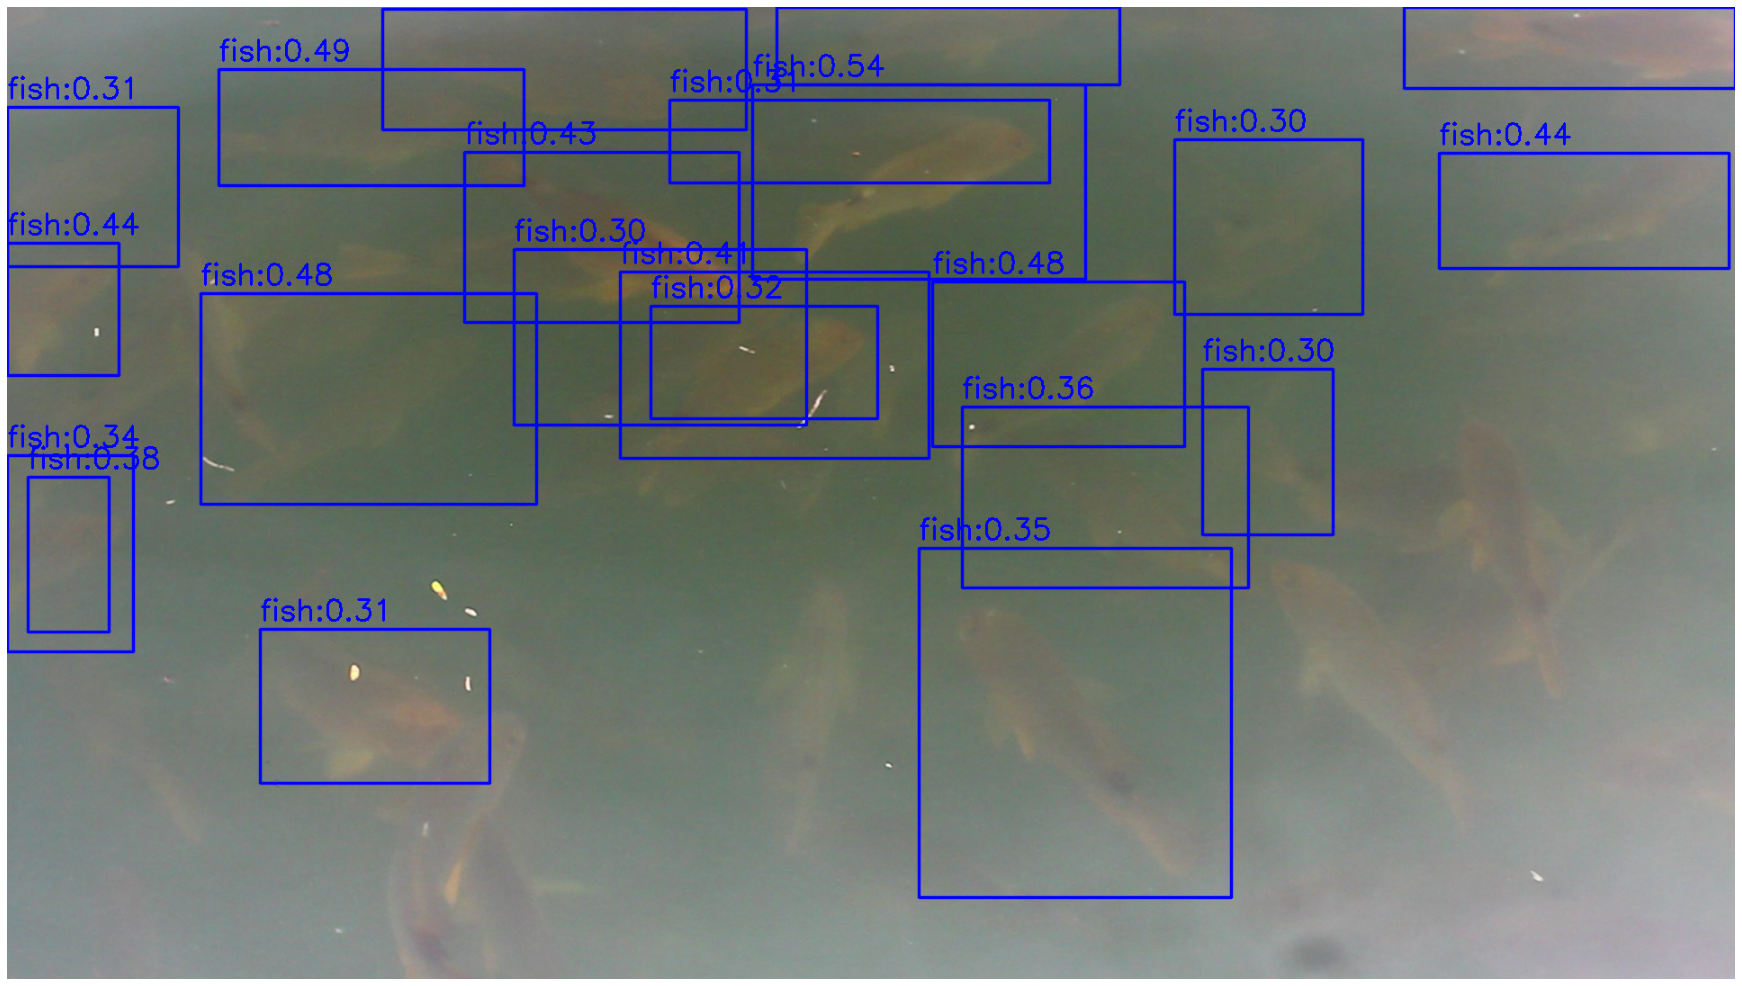

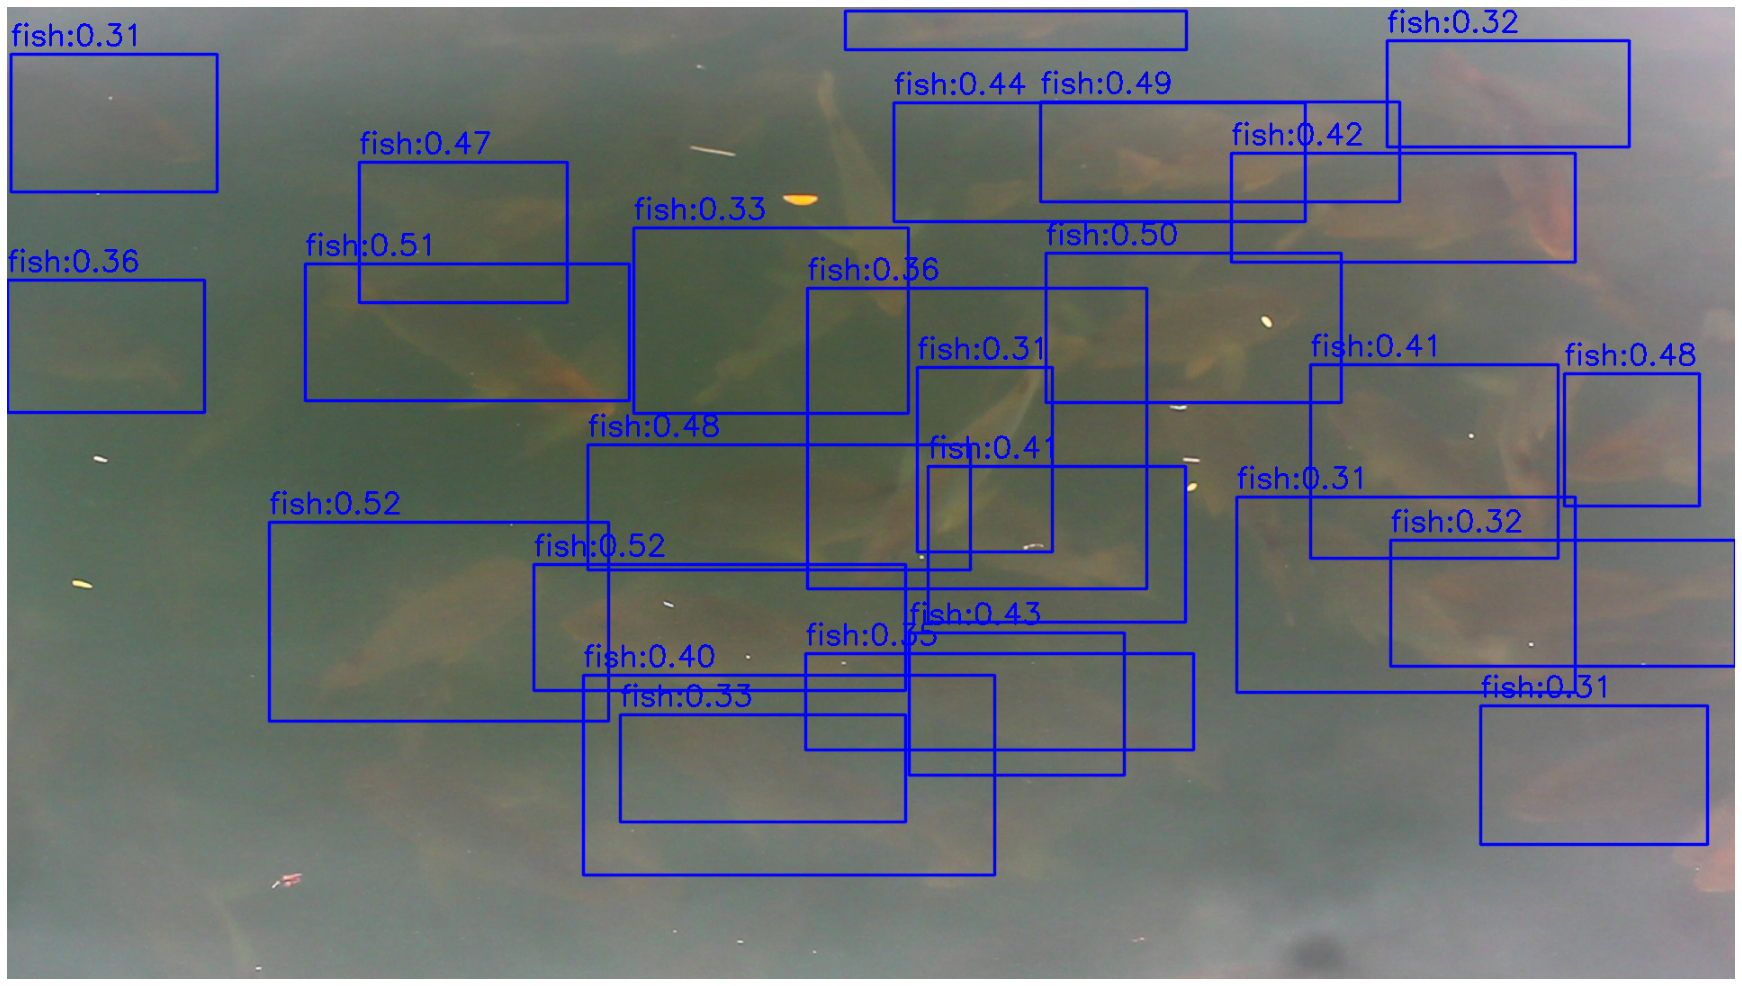

In [46]:
for image in os.listdir(test_files_dir):
    if image.lower().endswith(('.png', '.jpg', '.jpeg')):
        make_prediction(test_files_dir,image)